# Description of Dataset

**IMDB dataset having 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. It consists of a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So,we have to predict the number of positive and negative reviews using either classification or deep learning algorithms.So here we will use BERT and train it for classifying reviews as positive/negative correctly.**

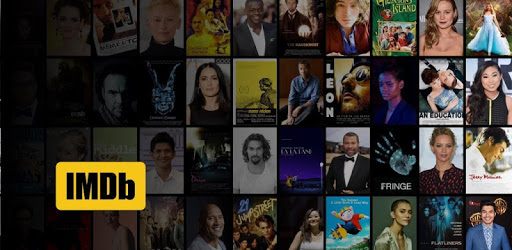

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# LOADING THE NECESSARY LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

# IMPORTING THE DATASET

In [ ]:
df=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

# DATA VISUALIZATION AND PREPROCESSING

In [ ]:
df.describe()

In [ ]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(df.sentiment)

**SO, WE CAN SEE THAT THE DATASET IS BALANCED**

In [ ]:
df.isna().sum() # Checking for any missing values

**WHAT ARE STOPWORDS?**

**Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.**

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

**BASIC DATA CLEANING**

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

In [ ]:
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)
df.head()

**WORDCLOUD FOR POSITIVE TEXT (LABEL - 1)**

In [ ]:
sns.set(style = "white" , font_scale = 1.2)

In [ ]:
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

**WORDCLOUD FOR NEGATIVE TEXT (LABEL - 0)**

In [ ]:
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

**Number of characters in texts**

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']==1]['review'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Text with Good Reviews')
text_len=df[df['sentiment']==0]['review'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Characters in texts')
plt.show()

**Number of words in each text**

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']==1]['review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Text with Good Reviews')
text_len=df[df['sentiment']==0]['review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Words in texts')
plt.show()

**Average word length in a text**

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['sentiment']==1]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Text with Good Reviews')
word=df[df['sentiment']==0]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Average word length in each text')

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.review)
corpus[:5]

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

In [ ]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Unigram Analysis**

In [ ]:
most_common_uni = get_top_text_ngrams(df.review,20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

**Bigram Analysis**

In [ ]:
most_common_bi = get_top_text_ngrams(df.review,20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Bigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

**Trigram Analysis**

In [ ]:
most_common_tri = get_top_text_ngrams(df.review,20,3)
most_common_tri = dict(most_common_tri)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Trigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

# BERT WORKING

**BERT relies on a Transformer (the attention mechanism that learns contextual relationships between words in a text). A basic Transformer consists of an encoder to read the text input and a decoder to produce a prediction for the task. Since BERT’s goal is to generate a language representation model, it only needs the encoder part. The input to the encoder for BERT is a sequence of tokens, which are first converted into vectors and then processed in the neural network. But before processing can start, BERT needs the input to be massaged and decorated with some extra metadata:**

**1. Token embeddings: A [CLS] token is added to the input word tokens at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.**

**2. Segment embeddings: A marker indicating Sentence A or Sentence B is added to each token. This allows the encoder to distinguish between sentences.**

**3. Positional embeddings: A positional embedding is added to each token to indicate its position in the sentence.**

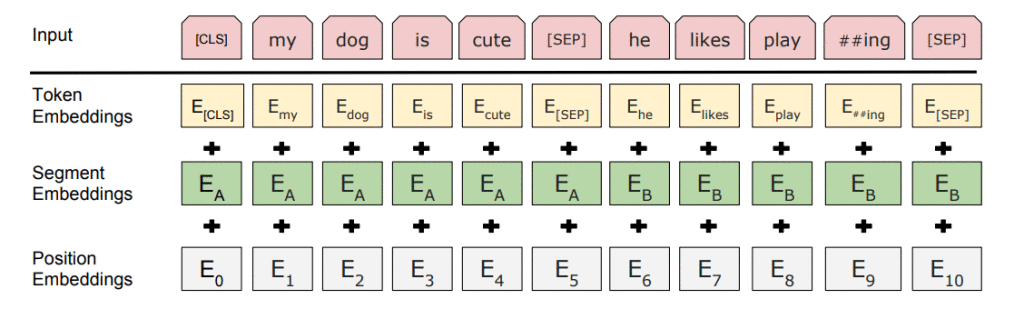

**Source Credits - https://towardsml.com/2019/09/17/bert-explained-a-complete-guide-with-theory-and-tutorial/**

# TRAINING THE MODEL

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df.review,df.sentiment,random_state = 0 , stratify = df.sentiment)

**Fast Encoding**

In [ ]:
from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
x_train = fast_encode(x_train.values, fast_tokenizer, maxlen=400)
x_test = fast_encode(x_test.values, fast_tokenizer, maxlen=400)

In [ ]:
def build_model(transformer, max_len=400):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
model = build_model(bert_model, max_len=400)
model.summary()

In [ ]:
history = model.fit(x_train,y_train,batch_size = 32 ,validation_data=(x_test,y_test),epochs = 3)

# ANALYSIS AFTER TRAINING OF MODEL

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = model.predict(x_test)
pred[:5]

In [ ]:
pred = np.round(pred).astype(int)
pred[:5]

In [ ]:
print(classification_report(y_test, pred, target_names = ['Bad Reviews','Good Reviews']))

In [ ]:
cm = confusion_matrix(y_test,pred)
cm

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

**PLS UPVOTE THIS NOTEBOOK IF YOU LIKE IT! THANKS FOR YOUR TIME !** 